# How to do 4K warming


## The design

The basic idea of this experiment is to look at the effekt of warming as a simple increase in temperature, without the dynamical effects (following Bony et al., 2004). This temperature increase should be sufficiently strong to cause a change in the model behaviour. A common convention is to use 4 kelvin surface warming which roughly reflects equilibrium climate sensitivity (ca. 2-5 kelvin according to the [IPCC AR6 report](https://www.ipcc.ch/report/ar6/wg1/figures/chapter-7/figure-7-18)). The spatial limitations of our model domain force us to think about the translation of this uniform surface warming into a warming of the air column. Vertical profiles are forcing the model over the whole run time and these vertical profiles have to be warmed in unison with the surface. Radtke et al. (2021) compared two variants of treating the vertical column: a uniform warming and a warming that follows a moist adiabat. They found no prominent difference in the effect these warmings have. None the less, the moist adiabatic warming is the more realistic representation of our understanding of global warming. In the tropics the temperature profile is set by deep convection and therefore follows a moist adiabat. With a warmer surface the (moist adiabatic) lapse rate changes. This produces more warming aloft, resulting in a warming that is roughly doubled at around 10 km height. This behaviour is generally acknowledged in context of the *lapse rate effect* (higher temperatures aloft increase outgoing longwave radiation). To construct our perturbation of the temperature profile ($\Delta{}T_h$) we calculate the moist adiabatic profiles over two surface temperatures with the set difference of 4 degree kelvin. The difference between these two profiles ($\Delta{}T_h$) is added onto the air temperature `temp` in the existing boundary conditions.

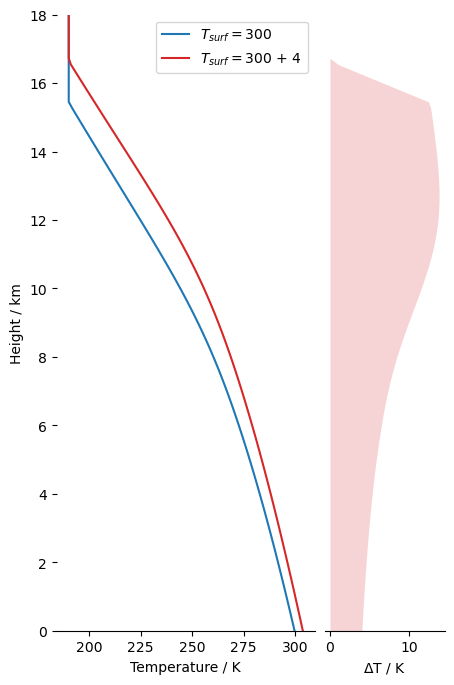

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import calculations as cc

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plot_utils as pu

def plot_adiabat(ax, p_surf, T_s, T_min, ymax, **kwargs):
    h = np.linspace(0, ymax, num=100)
    p = cc.hydrostratic_profile(h, p_surf)
    t = cc.konrad_moist_adiabat(p,  T_s=T_s, T_min=T_min)
    plot = ax.plot(t, h /1000, **kwargs)
    return plot

def ax_two_adiabats(ax, ymax, p_surf, T_s, T_min, deltaT):
    plot_adiabat(ax, p_surf, T_s, T_min, ymax, label='$T_{surf} = 300$')
    plot_adiabat(ax, p_surf, T_s+deltaT, T_min, ymax,  label='$T_{surf} = 300$ + ' + str(deltaT), color='tab:red')
    ax.set_xlabel('Temperature / K')
    ax.set_ylabel('Height / km')
    ax.set_ylim([0,ymax/1000])
    ax = pu.remove_spines(ax, ['left', 'right', 'top'])
    ax.legend()
    return ax

def add_delta_ax(ax, deltaT, ymax, p_surf, T_s, T_min):
    divider = make_axes_locatable(ax)
    ax_add = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    h = np.linspace(0, ymax, num=100)
    p = cc.hydrostratic_profile(h, p_surf)
    t = cc.konrad_moist_adiabat(p,  T_s=304, T_min=T_min) - cc.konrad_moist_adiabat(p,  T_s=300, T_min=T_min)
    ax_add.fill_between(t , h / 1000, alpha=0.2, color='tab:red', lw=0)
    ax_add = pu.remove_spines(ax_add, ['left', 'right', 'top'])
    ax_add = pu.remove_ticks(ax_add, ['left', 'right'])
    ax_add.set_xlabel('$\Delta$T / K')
    return ax_add

def fig_delta_from_moist_adiabats():
    deltaT = 4
    ymax = 18000
    p_surf = 100000
    T_s = 300
    T_min = 190.0
    figsize = (5,8)

    fig, ax = plt.subplots(figsize=figsize)
    ax =  ax_two_adiabats(ax, ymax, p_surf, T_s, T_min, deltaT)
    ax2 = add_delta_ax(ax, deltaT, ymax, p_surf, T_s, T_min)
    return fig, (ax,ax2)

fig, axs = fig_delta_from_moist_adiabats()
fig.savefig('img/fig_delta_from_moist_adiabats.png')
fig.show()

Where the amount of water vapour is controlled by the Clausius-Clapeyron relationship, the increasing temperature leads to an increase in specific humidity. A purely thermodynamic scaling based on a saturated troposphere gives a rate of increase in specific humidity of around 6 to 15 percent per degree kelvin (depending on the temperature with stronger increase for lower base temperatures; $\approx$6 for 300 K). GCMs are known to maintain a roughly constant relative humidity under warming. This should particularly hold true for our oceanic domain. Because we constantly force our model over the entire run time we should try to anticipate how it tends to equilibrate to reduce spin up effects on the boundaries. Thus we increase specific humidity `qv` in our boundaries to keep the relative humidity (not in the boundary conditions) fixed. 

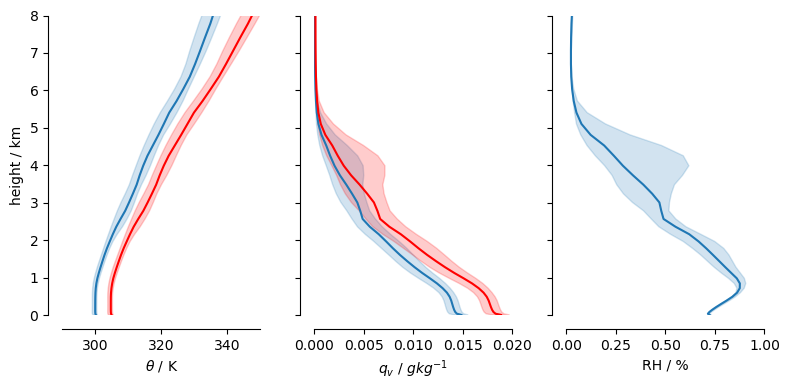

In [18]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import xarray as xr
import numpy as np
import calculations as cc
import matplotlib.pyplot as plt
import plot_utils as pu

def augment_profile(profile):
    return cc.add_relative_humidity(cc.add_prognostic_variables(profile))

def fetch_quantile(q, data_path='./data', latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    # creation done in 07_deltas.ipynb
    f = f'latbc_q{q*100:.0f}.nc'
    if f in os.listdir(data_path):
        d = xr.open_dataset(os.path.join(data_path, f))
    else:
        d = augment_profile(get_quantile_profiles(latbc_path, quantile=q))
        d.to_netcdf(os.path.join(data_path, f))
    return d

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def fetch_quantiles_and_heights(latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    quantile = dict()
    for q in [0.25,0.5,0.75]:
        quantile[q] = fetch_quantile(q, latbc_path=latbc_path)

    z = interpolate_full_level(quantile[0.5]['z_ifc'])/1000
    return quantile, z
    
def fig_boundary_conditions_radtke_like(quantile=False, z=False):
    if not quantile: quantile, z = fetch_quantiles_and_heights()
    
    color = 'tab:blue'
    variables = ['theta_v', 'qv', 'RH', 'u', 'v'][0:3]
    labels    = ['$\\theta}$ / K', '$q_v$ / $g kg^{-1}$', 'RH / %', 'u / $m s^{-1}$', 'v / $m s^{-1}$'][0:3]
    xlims     = [(290,350), (0,0.020), (0.0,1), (-20,20), (-10, 10)][0:3]
    ylim = (0, 8)

    fig, axs = plt.subplots(1,len(variables), figsize=(8,4))
    for ax, var, label, xlim in zip(axs, variables, labels, xlims):
        ax.fill_betweenx(z, quantile[0.25][var], quantile[0.75][var], alpha=0.2, color=color)
        ax.plot(quantile[0.50][var], z, color=color)
        ax.set_xlabel(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        pu.adjust_spines(ax, ['left', 'bottom'])
        if not ax == axs[0] : ax.set_yticklabels([])
    axs[0].set_ylabel('height / km')
    return fig, axs

def fig_boundary_conditions_variability_includedelta(quantile=False, z=False):
    cold = fetch_quantile(0.5, latbc_path='/work/mh1126/m300872/unchanged/latbc')

    h = np.flip(interpolate_full_level(cold['z_ifc'].values))
    T_s_0 = cold['temp'].values[-1]
    T_min = np.nanmin(cold['temp'].values)
    p_surf = cold['pres'].values[-1]
    T_increase = 4

    p = cc.hydrostatic_profile(h, p_surf=p_surf)
    delta = cc.joined_profile(p, T_s=T_s_0+T_increase, T_min=T_min) - cc.joined_profile(p, T_s=T_s_0, T_min=T_min)
    delta = np.flip(delta)

    quantiles, z = fetch_quantiles_and_heights()
    fig, axs = fig_boundary_conditions_radtke_like(quantiles, z)

    for key, value in quantiles.items():
        value = cc.add_relative_humidity(value)
        value['temp'].values +=  delta
        value = cc.restore_specific_humidity(value, drop_RH=False)
        value = cc.add_prognostic_variables(value)

    var = 'theta_v'; color = 'red'; ax = axs[0]
    ax.plot(quantiles[0.5][var], z, color=color)
    ax.fill_betweenx(z, quantiles[0.25][var], quantiles[0.75][var], alpha=0.2, color=color)

    var = 'qv'; color = 'red'; ax = axs[1]
    ax.plot(quantiles[0.5][var], z, color=color)
    ax.fill_betweenx(z, quantiles[0.25][var], quantiles[0.75][var], alpha=0.2, color=color)
    fig.tight_layout()
    return fig, axs

fig, axs = fig_boundary_conditions_variability_includedelta()
fig.savefig('img/fig_boundary_conditions_variability_includedelta.png')
fig.show()

## Pressure and density

ICON reads the boundary conditions in their diagnostic form, as pressure and temperature (`pres` and `temp`). Internally ICON works on the prognostic variables density and virtual potential temperature (`rho` and `theta_v`). After passing the boundary conditions to ICON, it will calculate the prognostic variables on the basis of temperature (increased), specific humidity (increased) and pressure (unchanged).

$$\rho = \frac{\epsilon p\,(1+w)}{R_dT\,(w+\epsilon)}$$

with $R_d$ being the specific gas constant of dry air, $\epsilon$ the molecular weight ratio between water vapor and dry air ($\epsilon\approx0.622$) and $\text{w}$ the mixing ratio ($w = q (1-q)^{-1}$).

$$ \theta_v = T (P_0 / P)^\kappa \frac{\text{w} + \epsilon}{\epsilon\,(1 + \text{w})} $$

with $\kappa$ being the Poisson constant and $P_0$ a reference pressure.

This way the increase in temperature leads to a reduction in air density, unless it is compensated by a decrease in pressure. In our first experiment (named **p_fix** hereafter) we do nothing with the pressure in the boundary conditions, thus implicitly we decrease the air density. This lead to an unforeseen drop in surface pressure. Not changing pressure at the boundaries decreases pressure inside the domain. This seems counterintuitive at first glance. But as mentioned above ICON only uses the pressure information to calculate density. Providing less dense air at the boundaries leads to mass loss inside the domain and the reduced air mass leads to reduced surface pressure.

To inhibit mass loss we tried to fix the density in our second experiment (named **rho_fix** hereafter). We save the information on air density, then manipulate the boundary conditions (increase temperature and specific humidity) and afterwards restore the density by decreasing pressure following the relationship given by the hydrostatic equation:

$$ p = \rho \cdot R_{\text{specific}} \cdot T $$

This indead does prevent the drop in surface pressure, but has its own side effects. When we decrease pressure to compensate for the increase in temperature, we produce a a pressure change that (inversly) follows our applied temperature delta with the most change at around 10 km height and no change in higher layers. The resulting profile is no longer in hydrostatic balance and a vigorous circulation is triggered, which results in strong winds (see interquartile range of wind variables in the domain mean timeseries below; <span style="color:red">red line</span> is the *rho_fix* run).

In [1]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import numpy as np
import xarray as xr
import calculations as cc
import postprocessing as pp
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import plot_utils as pu

def add_total_wind(data):
    data['u+v_10m'] = np.sqrt(data['u_10m']**2 + data['v_10m']**2)
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'u+v_10m'
    attributes['long_name'] = 'total wind'
    del(attributes['param'])
    data['u+v_10m'] = data['u+v_10m'].assign_attrs(attributes)
    return data

def calculate_quantiles(data, quantiles=[0.05, 0.50, 0.95]):
    ''' to provide the mean in the quantile dimension it is assigned to the value -0.5'''
    quantiles = [data.chunk(dict(cell=-1)).quantile(q, dim='cell', keep_attrs=True).assign_coords({'quantile':q}) for q in quantiles]
    quantiles.append(data.mean(dim='cell', keep_attrs=True).assign_coords({'quantile':-.5}))
    return xr.concat(quantiles, 'quantile')

def save_composit_timeseries(path, savename):
    def load_and_clean(path, keyword):
        files = [os.path.join(path,f) for f in os.listdir(path) if keyword in f]
        data = pp.open_mfdataset_with_timedoubles(files)
        data = pp.clean_surface_data(data)
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
        return data
    
    quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
    data = load_and_clean(path, 'surface')
    data = add_total_wind(data)
    surface = calculate_quantiles(data, quantiles=quantiles)
    data = load_and_clean(path, 'radiation')
    radiation = calculate_quantiles(data)
    xr.merge(pp.time_overlap([surface,radiation])).to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename):
    def load_and_clean(keyword):
        data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control[f'{keyword}_DOM01'].to_dask()
        data = data.where(data.time < data_to_match.time.values[-1], drop=True)
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
        return data
    
    quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
    data = load_and_clean('surface')
    data = add_total_wind(data)
    surface = calculate_quantiles(data, quantiles=quantiles)
    data = load_and_clean('radiation')
    radiation = calculate_quantiles(data, quantiles=quantiles)
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    try:    del(composit['height_bnds'])
    except: pass
    composit.to_netcdf(savename)
    
def fig_few_domain_means(data, varlist, labels, kwargs=False, verbose=False, integral=False, mean=False):
    if not kwargs: kwargs = [dict() for d in data]
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(1,len(varlist), figsize=(20,20/(len(varlist)+1)))

    for ax, var in zip(np.ravel(axs), varlist):
        for j, d in enumerate(data):
            x = [pd.to_datetime(t) for t in d['time'].values]
            x = [(t - d['time'].values[0]) /np.timedelta64(1,'h')  for t in d['time'].values]
            y = d[var].sel(quantile=-0.5).values
            
            if mean: ax.axhline(np.mean(y), **kwargs[j], ls=':')
            try:
                y_lo = d[var].sel(quantile=0.25).values
                y_hi = d[var].sel(quantile=0.75).values
                if j == 0: label = 'interquartile range'
                else: label=None
                ax.fill_between(x, y_lo, y_hi, **kwargs[j], alpha=0.1, label=label)
            except: pass
            ax.plot(x, y, label=labels[j], **kwargs[j])
            pu.remove_spines(ax)
        ax.set_title(data[0][var].attrs['long_name'])
        ax.set_ylabel(data[0][var].attrs['units'])
    axs[0].set_xlabel('time after start / h')
    if verbose: print('done')
    return fig, axs

def fixedfig_few_domain_means_warming_withboundaryzone(varlist, mean=False):
    
    warming_timeseries = f'data/rhofix_moistadabatic_{str(datetime.date.today())}.nc'
    control_timeseries = f'data/eurecasurface_{str(datetime.date.today())}.nc'
    pressure_drop_timeseries = f'data/pfix_moistadabatic_{str(datetime.date.today())}.nc'
    date = '2023-08-23'
    warming_timeseries = f'data/rhofix_moistadabatic_{date}.nc'
    control_timeseries = f'data/eurecasurface_{date}.nc'
    pressure_drop_timeseries = f'data/pfix_moistadabatic_{date}.nc'
    
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup', warming_timeseries)
        print('warming done')
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
        print('control done')
    if not os.path.exists(pressure_drop_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', pressure_drop_timeseries)
        print('pre done')
    
    ctrl = xr.open_dataset(control_timeseries)
    try:    del(ctrl['height_bnds'])
    except: pass
    rho_fix = xr.open_dataset(warming_timeseries)
    p_fix = xr.open_dataset(pressure_drop_timeseries)
    for data in [ctrl, rho_fix, p_fix]: data = add_total_wind(data)
    data = {'ctrl':ctrl, 'rho_fix':rho_fix, 'p_fix':p_fix}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [{'color' : 'blue'}, {'color' : 'red'}, {'color' : 'orange'}]
    
    fig, axs = fig_few_domain_means(data, varlist, labels, kwargs, mean=mean, verbose=False)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs, data

def add_total_wind(data):
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'u+v_10m'
    attributes['long_name'] = 'wind speed'
    del(attributes['param'])
    data[attributes['standard_name']] = np.sqrt(data['u_10m']**2 + data['v_10m']**2)
    data[attributes['standard_name']] = data[attributes['standard_name']].assign_attrs(attributes)
    
    attributes['standard_name'] = 'beta'
    attributes['long_name'] = 'wind direction'
    attributes['units'] = 'degree'
    data[attributes['standard_name']] = np.mod(np.degrees(np.arctan2(data['v_10m'], data['u_10m'])), 360)
    data[attributes['standard_name']] = data[attributes['standard_name']].assign_attrs(attributes)
    return data

varlist = ['pres_sfc', 'u_10m', 'v_10m']#, 'u+v_10m', 'beta']
fig, axs, data = fixedfig_few_domain_means_warming_withboundaryzone(mean=True, varlist=varlist)
np.ravel(axs)[0].set_ylim(99000,103000) # there is one strange outlier that compresses the rest of the plot to a line
fig.savefig(f'img/fig_domain_means_winds.png')
fig.show()

Because we want to look at thermodynamic effects of global warming separate from the dynamical effect we don't want to create artificial large scale circulation, especially because the sensitivity of trade cumulus to dynamical changes presumably is much larger than the sensitivity to thermodynamic effects (compare Bony et al., 2004). Small and meso scale circulations might be different under global warming (this is one of the things we are interested in looking into), but we expect the domain mean to be close to the control simulation. Similarly the pressure gradients and the overall wind direction should be similar.

(Videos of the snapshot plots below can be found [here](https://owncloud.gwdg.de/index.php/s/DxBROf1XBCEmbRV))

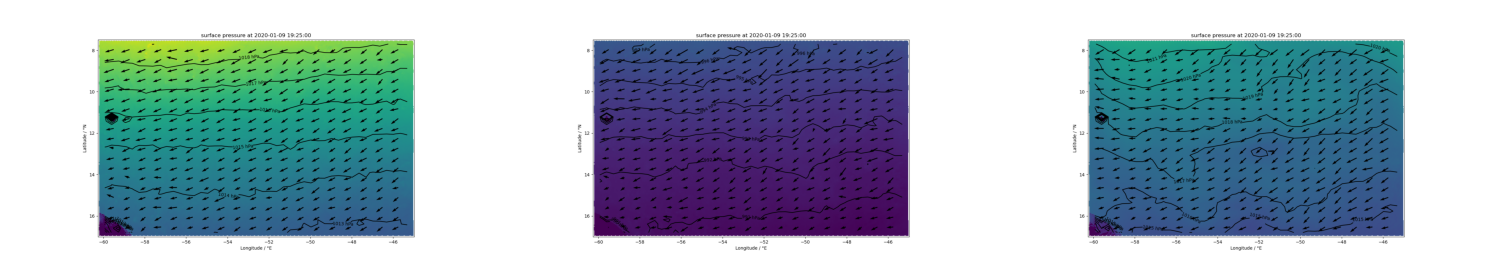

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

time = '19:25:00' # simulations start at 10:00
image_paths = [f'/scratch/m/m300872/quiver/ctrl_quiver_2020-01-09 {time}.png', 
               f'/scratch/m/m300872/quiver/presfix_quiver_2020-01-09 {time}.png', 
               f'/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 {time}.png']

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
for ax, path in zip(axs, image_paths):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Both *rho_fix* and *p_fix* show spinup behaviour. After roughly 8h both show the same trend as the control run, even though *p_fix* equilibrated in a ca. 30hPa lower domain mean pressure.

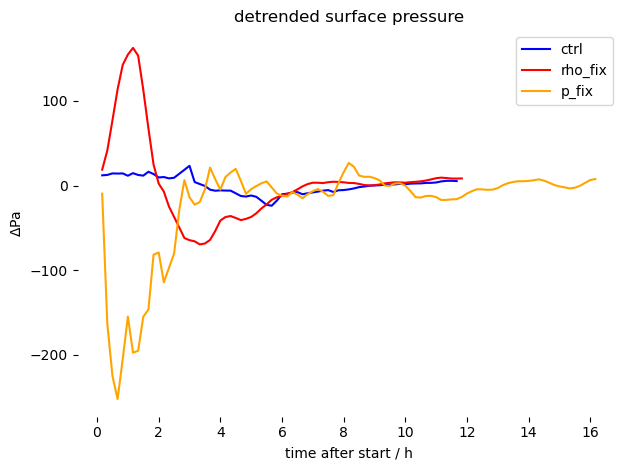

In [5]:
def fig_detrended_psurf(varlist, mean=False):
    warming_timeseries = f'data/rhofix_moistadabatic_{str(datetime.date.today())}.nc'
    control_timeseries = f'data/eurecasurface_{str(datetime.date.today())}.nc'
    pressure_drop_timeseries = f'data/pfix_moistadabatic_{str(datetime.date.today())}.nc'
    
    fig, ax = plt.subplots()
    var = 'pres_sfc'
    data = {'ctrl':xr.open_dataset(control_timeseries), 'rho_fix':xr.open_dataset(warming_timeseries), 'p_fix':xr.open_dataset(pressure_drop_timeseries)}
    labels, data = list(data.keys()), list(data.values())
    kwargs = [{'color' : 'blue'}, {'color' : 'red'}, {'color' : 'orange'}]
    for d, label, kwarg in zip(data, labels, kwargs):
        x = [pd.to_datetime(t) for t in d['time'].values]
        x = [(t - d['time'].values[0]) /np.timedelta64(1,'h')  for t in d['time'].values]
        y = d[var].sel(quantile=-0.5).values
        y = np.diff(y)
        x = x[1::]
        ax.plot(x,y, label=label, **kwarg)
    pu.remove_spines(ax)
    ax.set_title('detrended '+data[0][var].attrs['long_name'])
    ax.set_ylabel('$\Delta$'+data[0][var].attrs['units'])
    ax.set_xlabel('time after start / h')
    ax.legend()
    fig.tight_layout()
    return fig, ax

fig, ax = fig_detrended_psurf(mean=True, varlist=varlist)
fig.savefig('img/fig_detrended_psurf.png')
fig.show()

On a side note: both, the pressure drop in *p_fix* and the induced vertical circulation in *rho_fix* are problems of an open boundary LES with its constant exchange of data with the previously defined boundaries. In a global simulation density would decrease with warming in a similar way it does in our *p_fix* run. But because there is (there should be) no way for mass to escape a global grid, global mean surface pressure does not drop. 

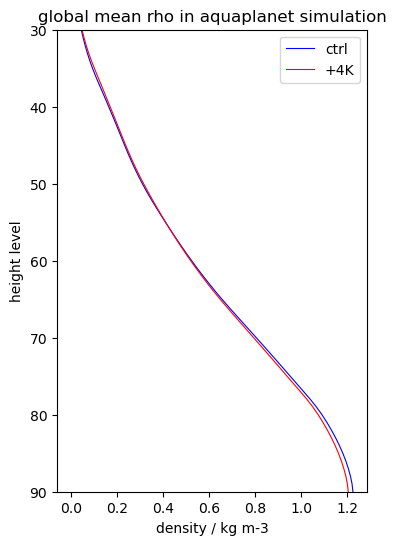

In [6]:
def get_aqua(path='/work/mh0287/m300901/experiments/aquaplanet_00/someinfo'):
    files = [os.path.join(path, f) for f in os.listdir(path) if 'dayavg_atm_3d_ml' in f]
    data = xr.open_mfdataset(files).rename({'ncells':'cell'})
    return data

def get_aqua4k(path='/work/mh0287/m300901/experiments_4k/aquaplanet_00/'):
    files = [os.path.join(path, f) for f in os.listdir(path) if 'dayavg_ml' in f]
    data = xr.open_mfdataset(files)
    files = [os.path.join(path, f) for f in os.listdir(path) if 'grid' in f]
    grid = xr.open_dataset(files[0])
    data = xr.merge([data.rename({'ncells':'cell'}), grid]).drop_vars(list(grid)).drop_dims(['vertex', 'edge'])
    return data

def fig_profiles(var):
    fig, ax = plt.subplots(figsize=(4,6))
    ctrl, warm = get_aqua(), get_aqua4k()
    for d, label, kwargs in zip([ctrl, warm], ['ctrl', '+4K'], [{'color':'blue'}, {'color':'red'}]):
        y = d.height.values
        x = d[var].mean(dim=['cell', 'time'])
        ax.plot(x, y, label=label, lw=.8, **kwargs)

    ax.set_xlabel(f'{ctrl[var].long_name} / {ctrl[var].units}')
    ax.set_ylabel('height level')
    ax.set_ylim(np.max(y), np.min(y))
    ax.legend()
    ax.set_ylim(90,30)
    ax.set_title(f'global mean {var} in aquaplanet simulation')
    return fig, ax

fig, ax = fig_profiles('rho')
fig.savefig('img/fig_aquajoso_density.png')
fig.show()

In [7]:
def clean_data(data):
    del(data['height_bnds'])
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = cc.add_relative_humidity(data)
    data = cc.replace_level_with_height(data)
    return data

def profile_at_time(path, timestep, verbose=False):
    files = [os.path.join(path,f) for f in os.listdir(path) if 'DOM01_3D' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if verbose: print(path, '\n', data.time.values)
    data = cc.replace_level_with_height(data, 'height_2')
    data = clean_data(data.sel(time=timestep))
    return calculate_quantiles(data, quantiles=[0.05, 0.25, 0.50, 0.75, 0.95])

def profile_eurecadata(timestep):
    keyword = '3D'
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control[f'{keyword}_DOM01'].to_dask()
    data = clean_data(data.sel(time=timestep))
    return calculate_quantiles(data,  quantiles = [0.05, 0.25, 0.50, 0.75, 0.95])

def ax_profile(ax, data, var):
    for run, color in zip(['rho_fix', 'p_fix', 'ctrl'], ['tab:red', 'tab:orange', 'tab:blue']):
        x1, x2 = data[run].sel(quantile=0.25)[var], data[run].sel(quantile=0.75)[var]   
        d = data[run].sel(quantile=0.5)
        y = d[d[var].dims[0]] / 1000
        x = d[var]
        ax.fill_betweenx(y,x1,x2, color=color, alpha=0.1)
        ax.plot(x,y, label=run, color=color, zorder=2.5)
    ax.set_title(d.time.values)
    ax.set_xlabel(d[var].attrs['long_name'] + ' / ' + d[var].attrs['units'])
    ax.set_ylabel('height / km')
    ax.legend()
    return ax

def fig_profiles_at_timestep(variables=['RH', 'w'], timestep='2020-01-09T21:00:00.000000000'):
    data = {'p_fix' : profile_at_time('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup', timestep), 
            'rho_fix' : profile_at_time('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', timestep),
            'ctrl' : profile_eurecadata(timestep)}

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1 = ax_profile(ax1, data, variables[0])
    ax2 = ax_profile(ax2, data, variables[1])
    ax2.set_title(None)
    y = data['ctrl'].height.values / 1000
    for ax in ax1, ax2: 
        ax = pu.remove_spines(ax, ['right', 'top'])
        ax.set_ylim(0, y[0])
    ax2.set_ylabel(None)
    ax2 = pu.remove_spines(ax2, ['left'])
    ax2 = pu.remove_ticks(ax2, ['left', 'right'])
    return fig, (ax1,ax2)

In [8]:
fig, axs = fig_profiles_at_timestep(timestep='2020-01-09T18:00:00.000000000', variables=['v', 'u'])
fig.savefig('img/fig_profiles_u_v_2020-01-09T18:00:00.png')
fig.show()

In [9]:
fig, axs = fig_profiles_at_timestep(timestep='2020-01-09T18:00:00.000000000')
axs[1].axvline(0, color='black', ls=':')
fig.savefig('img/fig_profiles_RH_w_2020-01-09T18:00:00.png')
fig.show()

## Surface fluxes and humidity structure 


Surface fluxes are a result the gradient at the surface, the airs capacity, turbulence (and thus wind), and a coefficient that can be dependent on temperature, pressure or salinity. A typical parametrisation can look like this:

\begin{equation}
Q_{LH} = \rho \cdot L_e \cdot c_e \cdot W \cdot (q_s - q_a)
\end{equation}

\begin{equation}
Q_{SH} = \rho \cdot c_p \cdot c_h \cdot W \cdot (T_s - T_a)
\end{equation}

where $L_e$ is the latent heat of vaporisation (a function of sea surface temperature), $c_p$ is the specific heat capacity of air, $c$ are turbulent exchange coefficients (Yu, 2009).
% Where the amount of water vapour is controlled by the Clausius-Clapeyron relationship, the increasing temperature leads to an increase in specific humidity. A purely thermodynamic scaling based on a saturated troposphere gives a rate of increase in specific humidity of around 6 to 15 percent per degree kelvin (depending on the temperature with stronger increase for lower base temperatures; $\approx$6 for 300 K; O'Gorman et al., 2010). 

The increase in temperature that we apply to our model should lead to higher surface fluxes. But the fluxes we see in the model are much higher than anticipated (latent heat flux almost doubles). While relative humidity seems to have opposing trends (higher than control for `p_fix`, lower than control for `rho_fix`), their surface fluxes are suprisingly close to each other.



In [29]:
varlist = ['shfl_s', 'lhfl_s', 'rh_2m']#, 'tqv_dia']
fig, axs, data = fixedfig_few_domain_means_warming_withboundaryzone(mean=True, varlist=varlist)
fig.savefig(f'img/fig_domain_means_fluxes.png')
fig.show()

In [ ]:
Does the pressure have an effect on 

In [11]:
1.06**4 * 200

252.49539200000007

larger variability in vertical motion in the warming run:

pure pressure effect?

In [12]:
import chemicals # help(chemicals.Watson)
import numpy as np
import scipy.constants

def boiling_point(P,T):
    # https://en.wikipedia.org/wiki/Boiling_point
    R = scipy.constants.gas_constant
    P_ref = 100000
    T_ref = 373.15 # K
    Hvap_ref = 40660 # J/mol
    Tc = 647.096 # K
    
    deltaHvap = chemicals.Watson(T, Hvap_ref, T_ref, Tc)
    return 1 / ((1 / T_ref) - (R * np.log(P/P_ref))/(deltaHvap))

# for P in [99000, 100000, 102000]:
#     print(P, ':', boiling_point(P,300))    
boiling_point(102000,300) - boiling_point(99000,300)

0.7774256847837933

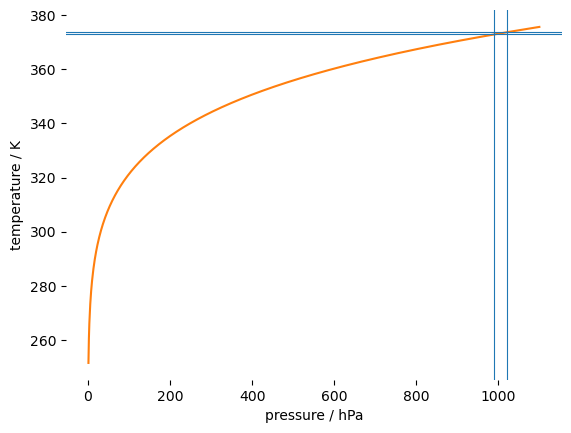

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
P = np.linspace(100, 110000, 1000)
ax.plot(P / 100,boiling_point(P,304), color='tab:orange')
for p in [990,1020]:
    ax.axvline(p, lw=0.8)
    ax.axhline(boiling_point(p*100, 300), lw=0.8)
ax.set_xlabel('pressure / hPa')
ax.set_ylabel('temperature / K')
for border in ['top','bottom','left','right']: ax.spines[border].set_visible(False)
fig.savefig('img/fig_boiling_point.png')

In [14]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import pandas as pd

import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

def filelist(path, mask):
    return [os.path.join(path, f) for f in os.listdir(path) if mask in f]

def filelist_3D():
    return filelist('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup', 'DOM01_3D_')

def get_3D(cut_borders=False):
    files = filelist_3D()
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    data = pp.add_grid(data)
    if cut_borders: data = pp.cut_borders(data)
    try: 
        data['w'] = data['w'].swap_dims({'height_2':'height'})
        data = data.drop_vars('height_2')
    except: pass
    try: data = data.drop_vars('height_bnds')
    except: pass
    # data = cc.replace_level_with_height(data, 'height')
    return data


# data = get_3D(cut_borders=True)

# data


# nearest_pressure_index = abs(data['pres'] - 50000).argmin(dim='height')
# w_500hPa = data['w'].isel(height=nearest_pressure_index.compute())
# w_500hPa_plus = w_500hPa.where(x_variable > 0)
# i can just take a constant level in this domain. no need be very picky with the pressure level.

In [15]:
# import file_handling as fh
# import matplotlib.pyplot as plt
# import plot_utils as pu

# def load_mintake():
#     data = fh.MinIntake()
#     data.ctrl = fh.MinIntake()
#     data.warm = fh.MinIntake()
#     data.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
#     data.warm.latbc = xr.open_dataset('data/profile_warm_latbc.nc')
#     data.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
#     data.warm.initcon = xr.open_dataset('data/profile_warm_initcon.nc')
#     return data

# def fig_profiles(data, verbose=False):
#     figsize=(8,8)
#     fig, axs = plt.subplots(1,2, figsize=figsize)
#     y = data.ctrl.initcon['z'].values / 1000
#     kwargs=[{'color' : 'blue'}, {'color' : 'red'},]
#     labels = ['ctrl.latbc', 'warm.latbc']

#     ax = axs[0]
#     arrays = [data.ctrl.latbc['theta_v'].values, data.warm.latbc['theta_v'].values]
#     if verbose: 
#         print('surface virtual potential temperature:')
#         for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
#     for x, kw in zip(arrays, kwargs):
#         ax.plot(x,y,**kw)
#     ax.set_xlabel('virtual potential temperature / K')
#     ax.set_xlim([290,500])

#     ax = axs[1]
#     arrays = [data.ctrl.latbc['rho'].values, data.warm.latbc['rho'].values]
#     if verbose: 
#         print('surface density:')
#         for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
#     for x, kw, label in zip(arrays, kwargs, labels):
#         ax.plot(x,y,**kw, label=label)
#     ax.set_xlabel('virtual potential temperature / K')
#     ax.set_xlabel('density')
#     ax.legend()

#     for ax in axs: 
#         pu.remove_spines(ax)
#         ax.set_ylabel('Height / km')
#         ax.set_ylim([0,23])
#     return fig, axs
    
# fig, axs = fig_profiles(load_mintake())
# fig.show()

## References

- Bony, S., Dufresne, J. L., Le Treut, H., Morcrette, J. J., & Senior, C. (2004). On dynamic and thermodynamic components of cloud changes. *Climate dynamics*, 22, 71-86. [link](https://doi.org/10.1007/s00382-003-0369-6)

- O’Gorman, P. A., & Muller, C. J. (2010). How closely do changes in surface and column water vapor follow Clausius–Clapeyron scaling in climate change simulations?. *Environmental Research Letters*, 5(2), 025207. ([link](https://iopscience.iop.org/article/10.1088/1748-9326/5/2/025207/meta))
- Radtke, J., Mauritsen, T., & Hohenegger, C. (2021). Shallow cumulus cloud feedback in large eddy simulations–bridging the gap to storm-resolving models. *Atmospheric Chemistry and Physics*, 21(5), 3275-3288. ([link](https://doi.org/10.5194/acp-21-3275-2021))
- Vecchi, G. A., & Soden, B. J. (2007). Global warming and the weakening of the tropical circulation. *Journal of Climate*, 20(17), 4316-4340. ([link](https://journals.ametsoc.org/view/journals/clim/20/17/jcli4258.1.xml))
- Yu, L. (2009). Sea surface exchanges of momentum, heat and fresh water determined by satellite. *Elements of Physical Oceanography: A derivative of the Encyclopedia of Ocean Sciences*, 110. ([link](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/latent-heat-flux))

In [16]:
print('bonus figure')
import numpy as np
import matplotlib.pyplot as plt

fig, ax  = plt.subplots()
for phi in np.linspace(0,4,30):
    x = np.linspace(0,9,1000) 
    y = np.sin(x+phi) 
    ax.plot(x,y)
for border in ['top','bottom','left','right']: ax.spines[border].set_visible(False)
ax.tick_params(left=0, right=0, bottom=0, labelleft=0, labelbottom=0)

bonus figure
